# Data Cleaning

Data cleaning is the process of detecting and removing errors and inconsistencies from the data to improve its quality. Inproper data cleaning process can lead to errors, faulty analysis, distortion in dataset and eventually incompatible datasets for machine learning purposes. There is no one absolute way to prescribe the exact steps in the data cleaning process because the processes will vary from dataset to dataset. My data cleaning process includes:

* Check the data types
* Check for duplicates - Primary key ('tweets.id')
* Check missing values
* Make text all lower case
* Remove links and images
* Remove hashtags
* Remove @ mentions
* Remove emojis
* Remove stop words
* Remove punctuation
* Get rid of stuff like "what's" and making it "what is'
* Stemming / lemmatization




In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install -qqq ftfy

     |████████████████████████████████| 64 kB 1.5 MB/s 


In [4]:
## Import required libraries
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import re
import ftfy
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from PIL import Image # for opening, manipulating, and saving many different image file f
# WordCloud - Python linrary for creating image wordclouds
from wordcloud import WordCloud
from nltk import pos_tag # For Parts of Speech tagging
import random # generating random numbers


In [5]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [6]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [7]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [8]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

## Load the datasets

In [9]:
depressive_tweets_df = pd.read_csv("/content/drive/MyDrive/NLP/Depression_Detection/Data_fetch_API/output/depressive_tweets.csv")
random_tweets_df = pd.read_csv("/content/drive/MyDrive/NLP/Depression_Detection/Depression_tweets_Data/Data1/Sentiment Analysis Dataset 2.csv", 
                               encoding = "ISO-8859-1", usecols = range(0,4), nrows = 25000)

In [10]:
depressive_tweets_df.head()

,Unnamed: 0,tweet.id,created_at,text,location,retweet,favorite
0,0,1447537898572574730,2021-10-11 12:21:43,Open discussion. Between the Transfer Portal a...,Cheyenne Wyoming,0,0
1,1,1447540582490988553,2021-10-11 12:32:23,Plenty of things are changing in my life and t...,NaN,0,0
2,2,1447807717859491842,2021-10-12 06:13:53,I feel a little hopeless. Anyone else? #hopele...,NaN,0,0
3,3,1448076026219692033,2021-10-13 00:00:03,"Which is more healthy? Hope, or hopelessness? ...","Denver, CO",0,0
4,4,1448382047375040513,2021-10-13 20:16:04,So someone tell me how do I get over #HOPELESS...,Portland Or .,0,2


In [11]:
random_tweets_df.head()

,ï»¿ItemID,Sentiment,SentimentSource,SentimentText
0,1,0,Sentiment140,is so sad for my APL frie...
1,2,0,Sentiment140,I missed the New Moon trail...
2,3,1,Sentiment140,omg its already 7:30 :O
3,4,0,Sentiment140,.. Omgaga. Im sooo im gunna CRy. I'...
4,5,0,Sentiment140,i think mi bf is cheating on me!!! ...


In [12]:
## Slicing the random tweets to have sentiment == 1 
new_rand_df = random_tweets_df[random_tweets_df.Sentiment == 1]
new_rand_df.reset_index(inplace=True)

In [13]:
new_rand_df.shape

(12175, 5)

In [14]:
new_rand_df.head()

,index,ï»¿ItemID,Sentiment,SentimentSource,SentimentText
0,2,3,1,Sentiment140,omg its already 7:30 :O
1,6,7,1,Sentiment140,Juuuuuuuuuuuuuuuuussssst Chillin!!
2,8,9,1,Sentiment140,handed in my uniform today . i miss you ...
3,9,10,1,Sentiment140,hmmmm.... i wonder how she my number @-)
4,11,12,1,Sentiment140,thanks to all the haters up in my face a...


12175 random tweets with sentiment == 1

## Data Cleaning-Processing:

In [15]:
print(depressive_tweets_df.shape)
print(new_rand_df.shape)

(16943, 7)
(12175, 5)


In [16]:
## Check the data type of each column
depressive_tweets_df.dtypes.to_frame().rename(columns={0:'data_type'})

,data_type
Unnamed: 0,int64
tweet.id,int64
created_at,object
text,object
location,object
retweet,int64
favorite,int64


In [17]:
## Check the data type of each column
new_rand_df.dtypes.to_frame().rename(columns={0:'data_type'})

,data_type
index,int64
ï»¿ItemID,int64
Sentiment,int64
SentimentSource,object
SentimentText,object


In [18]:
## Drop unnecessary columns
depressive_tweets_df.drop(columns=['Unnamed: 0'], inplace=True)
new_rand_df.drop(columns=['ï»¿ItemID', 'index','Sentiment', 'SentimentSource'], inplace=True)

Since we are mostly dealing with the tweets in our datasets, it is not necessary to change the data types at this stage.

In [19]:
## Finding unique values in each column
for col in depressive_tweets_df:
    print("There are ", len(depressive_tweets_df[col].unique()), "unique values in ", col)

There are  11481 unique values in  tweet.id
There are  11387 unique values in  created_at
There are  10895 unique values in  text
There are  3186 unique values in  location
There are  66 unique values in  retweet
There are  136 unique values in  favorite


By considering **tweet.id** as our primary key, we have **11481** unique tweets, so we need to get rid of the duplicates.

In [20]:
## Finding unique values in each column
for col in new_rand_df:
    print("There are ", len(new_rand_df[col].unique()), "unique values in ", col)

There are  12175 unique values in  SentimentText


No duplicates in random tweets dataset

In [21]:
# drop duplicate values in tweet.id
depressive_tweets_df.drop_duplicates(subset=['tweet.id'], inplace=True)

In [22]:
depressive_tweets_df.reset_index(inplace=True)

In [23]:
depressive_tweets_df.shape

(11481, 7)

In [24]:
## Find the number of Null values in each columns
depressive_tweets_df.isnull().sum().to_frame().rename(columns={0:'Null values'})

,Null values
index,0
tweet.id,0
created_at,0
text,0
location,3957
retweet,0
favorite,0


There are **3957** Null values in the **location** columns but since location will not be used in our analysis or as a feature in our model, we don't need to replace them.

In [25]:
## Find the number of Null values in each columns
new_rand_df.isnull().sum().to_frame().rename(columns={0:'Null values'})

,Null values
SentimentText,0


No Null values in random tweets dataset.

In [26]:
## Drop all the columns except index, tweet.id and text
new_dep_df = depressive_tweets_df[['text']]

In [27]:
## Add label to both datasets (0 is non-depressive and 1 is depressive)
new_dep_df['label'] = pd.Series([1 for x in range(len(new_dep_df.index))])
new_rand_df['label'] = pd.Series([0 for x in range(len(new_rand_df.index))])

In [28]:
new_dep_df

,text,label
0,Open discussion. Between the Transfer Portal a...,1
1,Plenty of things are changing in my life and t...,1
2,I feel a little hopeless. Anyone else? #hopele...,1
3,"Which is more healthy? Hope, or hopelessness? ...",1
4,So someone tell me how do I get over #HOPELESS...,1
...,...,...
11476,Never underestimate the power of stupid people...,1
11477,Just found one of my garden foxes dead at the ...,1
11478,I legit just went to write the date as '26/10/...,1
11479,I'm currently feeling #Sad.,1


In [30]:
## Change the column name to be aligned with depressive dataset
new_rand_df.rename(columns={'SentimentText': 'text'}, inplace=True)

In [31]:
new_rand_df

,text,label
0,omg its already 7:30 :O,0
1,Juuuuuuuuuuuuuuuuussssst Chillin!!,0
2,handed in my uniform today . i miss you ...,0
3,hmmmm.... i wonder how she my number @-),0
4,thanks to all the haters up in my face a...,0
...,...,...
12170,@4_Feathers Oh! I get it! I think it's mandato...,0
12171,@4_hugh for the fifth time in the cinema AND I...,0
12172,@4_PACK i think i am in love with you,0
12173,@4_s_m_4 well i just made it back too. Really ...,0


In [34]:
## Combine two dataframes together

df_all = pd.concat([new_dep_df, new_rand_df], ignore_index=True)

In [35]:
df_all

,text,label
0,Open discussion. Between the Transfer Portal a...,1
1,Plenty of things are changing in my life and t...,1
2,I feel a little hopeless. Anyone else? #hopele...,1
3,"Which is more healthy? Hope, or hopelessness? ...",1
4,So someone tell me how do I get over #HOPELESS...,1
...,...,...
23651,@4_Feathers Oh! I get it! I think it's mandato...,0
23652,@4_hugh for the fifth time in the cinema AND I...,0
23653,@4_PACK i think i am in love with you,0
23654,@4_s_m_4 well i just made it back too. Really ...,0


In [36]:
# Expand Contraction
cList = {
  "ain't": "am not",
  "aren't": "are not",
  "can't": "cannot",
  "can't've": "cannot have",
  "'cause": "because",
  "could've": "could have",
  "couldn't": "could not",
  "couldn't've": "could not have",
  "didn't": "did not",
  "doesn't": "does not",
  "don't": "do not",
  "hadn't": "had not",
  "hadn't've": "had not have",
  "hasn't": "has not",
  "haven't": "have not",
  "he'd": "he would",
  "he'd've": "he would have",
  "he'll": "he will",
  "he'll've": "he will have",
  "he's": "he is",
  "how'd": "how did",
  "how'd'y": "how do you",
  "how'll": "how will",
  "how's": "how is",
  "I'd": "I would",
  "I'd've": "I would have",
  "I'll": "I will",
  "I'll've": "I will have",
  "I'm": "I am",
  "I've": "I have",
  "isn't": "is not",
  "it'd": "it had",
  "it'd've": "it would have",
  "it'll": "it will",
  "it'll've": "it will have",
  "it's": "it is",
  "let's": "let us",
  "ma'am": "madam",
  "mayn't": "may not",
  "might've": "might have",
  "mightn't": "might not",
  "mightn't've": "might not have",
  "must've": "must have",
  "mustn't": "must not",
  "mustn't've": "must not have",
  "needn't": "need not",
  "needn't've": "need not have",
  "o'clock": "of the clock",
  "oughtn't": "ought not",
  "oughtn't've": "ought not have",
  "shan't": "shall not",
  "sha'n't": "shall not",
  "shan't've": "shall not have",
  "she'd": "she would",
  "she'd've": "she would have",
  "she'll": "she will",
  "she'll've": "she will have",
  "she's": "she is",
  "should've": "should have",
  "shouldn't": "should not",
  "shouldn't've": "should not have",
  "so've": "so have",
  "so's": "so is",
  "that'd": "that would",
  "that'd've": "that would have",
  "that's": "that is",
  "there'd": "there had",
  "there'd've": "there would have",
  "there's": "there is",
  "they'd": "they would",
  "they'd've": "they would have",
  "they'll": "they will",
  "they'll've": "they will have",
  "they're": "they are",
  "they've": "they have",
  "to've": "to have",
  "wasn't": "was not",
  "we'd": "we had",
  "we'd've": "we would have",
  "we'll": "we will",
  "we'll've": "we will have",
  "we're": "we are",
  "we've": "we have",
  "weren't": "were not",
  "what'll": "what will",
  "what'll've": "what will have",
  "what're": "what are",
  "what's": "what is",
  "what've": "what have",
  "when's": "when is",
  "when've": "when have",
  "where'd": "where did",
  "where's": "where is",
  "where've": "where have",
  "who'll": "who will",
  "who'll've": "who will have",
  "who's": "who is",
  "who've": "who have",
  "why's": "why is",
  "why've": "why have",
  "will've": "will have",
  "won't": "will not",
  "won't've": "will not have",
  "would've": "would have",
  "wouldn't": "would not",
  "wouldn't've": "would not have",
  "y'all": "you all",
  "y'alls": "you alls",
  "y'all'd": "you all would",
  "y'all'd've": "you all would have",
  "y'all're": "you all are",
  "y'all've": "you all have",
  "you'd": "you had",
  "you'd've": "you would have",
  "you'll": "you you will",
  "you'll've": "you you will have",
  "you're": "you are",
  "you've": "you have"
}

c_re = re.compile('(%s)' % '|'.join(cList.keys()))

def expandContractions(text, c_re=c_re):
    def replace(match):
        return cList[match.group(0)]
    return c_re.sub(replace, text)

In [37]:
## Function to perform stepwise cleaning process
def tweets_cleaner(tweets):
  cleaned_tweets = []
  for tweet in tweets:
    tweet = tweet.lower() #lowercase
    
    # if url links then don't append to avoid news articles
    # also check tweet length, save those > 5 
    if re.match("(\w+:\/\/\S+)", tweet) == None and len(tweet) > 5:
    
      #remove hashtag, @mention, emoji and image URLs
      tweet = ' '.join(re.sub("(@[A-Za-z0-9]+)|(\#[A-Za-z0-9]+)|(<Emoji:.*>)|(pic\.twitter\.com\/.*)", " ", tweet).split())

      #fix weirdly encoded texts
      tweet = ftfy.fix_text(tweet)

      #expand contraction
      tweet = expandContractions(tweet)


      #remove punctuation
      tweet = ' '.join(re.sub("([^0-9A-Za-z \t])", " ", tweet).split())

      #stop words and lemmatization
      stop_words = set(stopwords.words('english'))
      word_tokens = nltk.word_tokenize(tweet)

      lemmatizer=WordNetLemmatizer()
      filtered_sentence = [lemmatizer.lemmatize(word) for word in word_tokens if not word in stop_words]
      tweet = ' '.join(filtered_sentence) # join words with a space in between them

      cleaned_tweets.append(tweet)

  return cleaned_tweets


## Data exploration:

To get the most common words used to depressive dataset, the POS-tag (Parts of Speech tagging) module in the NLTK library was used. Using the WordCloud library, one can generate a Word Cloud based on word frequency and superimpose these words on any image. In this case, I used the Twitter logo and Matplotlib to display the image. The Word Cloud shows the words with higher frequency in bigger text size while the "not-so" common words are in smaller text sizes.

In [90]:
# function to obtain adjectives from tweets
def getAdjectives(tweet):
    tweet = nltk.word_tokenize(tweet)  # convert string to tokens
    tweet = [word for (word, tag) in pos_tag(tweet)
             if tag == "JJ"]  # pos_tag module in NLTK library
    return " ".join(tweet)  # join words with a space in between them

In [91]:
# Apply getAdjectives function to the processed tweets 
# Extract all tweets into one long string with each word separate with a "space"
tweets_long_string = [getAdjectives(x) for x in X_d]
tweets_long_string = " ".join(tweets_long_string)

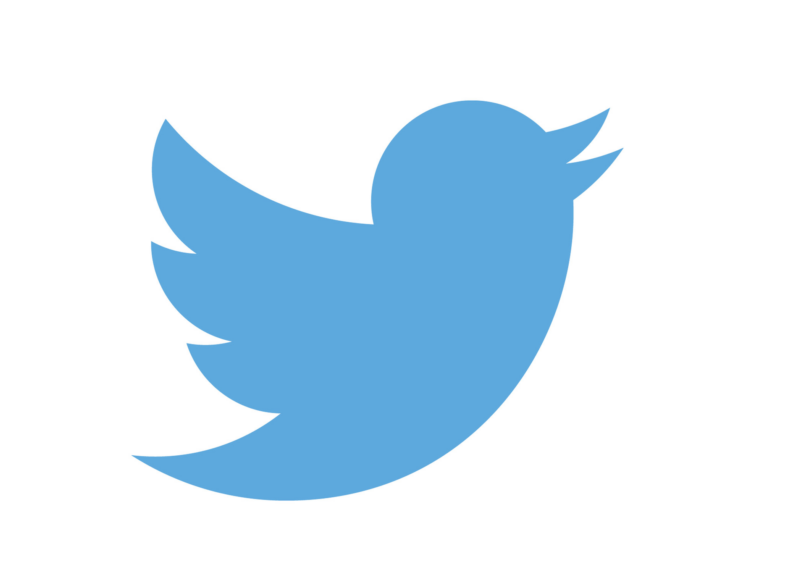

In [96]:
# Import Twitter Logo
image = np.array(Image.open('/content/drive/MyDrive/NLP/Depression_Detection/data_cleaning/logo.jpeg'))
    
fig = plt.figure() # Instantiate the figure object
fig.set_figwidth(14) # set width
fig.set_figheight(18) # set height

plt.imshow(image, cmap=plt.cm.gray, interpolation='bilinear') # Display data as an image
plt.axis('off') # Remove axis
plt.show() # Display image

In [97]:
# Create function to generate the blue colour for the Word CLoud

def blue_color_func(word, font_size, position, orientation, random_state=None,**kwargs):
    return "hsl(210, 100%%, %d%%)" % random.randint(50, 70)

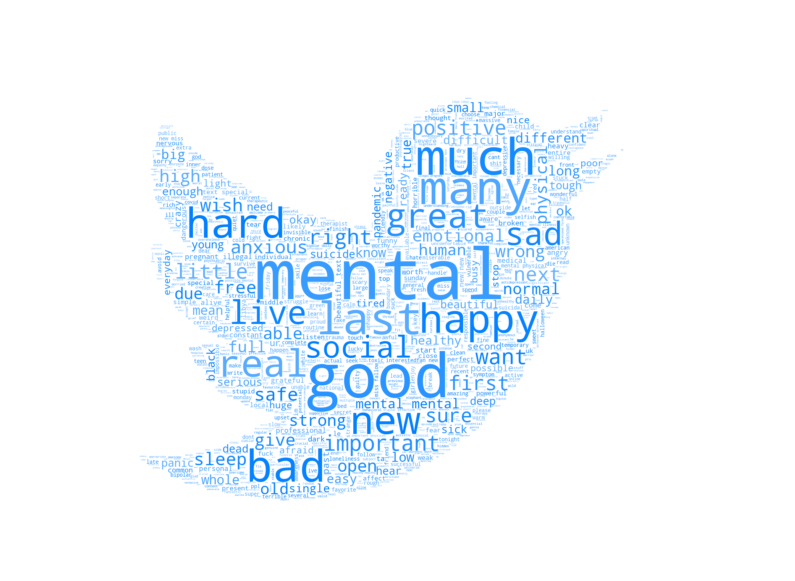

In [98]:
# Instantiate the Twitter word cloud object
twitter_wc = WordCloud(background_color='white', max_words=1500, mask=image)

# generate the word cloud
twitter_wc.generate(tweets_long_string)

# display the word cloud
fig = plt.figure()
fig.set_figwidth(14)  # set width
fig.set_figheight(18)  # set height

plt.imshow(twitter_wc.recolor(color_func=blue_color_func, random_state=3),
           interpolation="bilinear")
plt.axis('off')
plt.show()

In [99]:
twitter_wc.to_file("/content/drive/MyDrive/NLP/Depression_Detection/data_cleaning/wordcloud.png") #save to a png file

**Analyzing Top Words in the Word Cloud**

In [100]:
# Combine all words into a list
tweets_long_string = [getAdjectives(x) for x in X_d]
tweets_list=[]
for item in tweets_long_string:
    item = item.split()
    for i in item:
        tweets_list.append(i)

In [101]:
# Use the Built-in Python Collections module to determine Word frequency
from collections import Counter
counts = Counter(tweets_list)
df = pd.DataFrame.from_dict(counts, orient='index').reset_index()
df.columns = ['Words', 'Count']
df.sort_values(by='Count', ascending=False, inplace=True)

In [102]:
df.head(10)  # Check dataframe first 10 rows

,Words,Count
86,mental,906
88,good,483
26,u,477
9,much,316
179,new,300
31,many,272
94,last,246
19,bad,238
41,hard,209
50,happy,209


## Cleaning combined dataset

In [43]:
tweets_arr = [x for x in df_all['text']]

In [44]:
corpus = tweets_cleaner(tweets_arr)

In [45]:
corpus[:20]

['open discussion transfer portal nil become obsolete organization governing body',
 'plenty thing changing life life around one thing change',
 'feel little hopeless anyone else',
 'healthy hope hopelessness',
 'someone tell get live world surrounded people help u much better son inability care would likely give hopelessness darkness',
 'parent deserves experience indian legal system',
 'also look lot like feel like worse place sometimes',
 'glad tackling huge professional shortage facing saddened really living post pandemic world palpable every level department system',
 'know someone depressed please resolve never ask straightforward response bad situation depression like weather try understand blackness lethargy loneliness going',
 'every year pass pain remains painful struggle silently world busy enjoying life emotional support pain',
 'life expect thing favor take break go back nothing one feel misplaced like turtle horse race',
 'holiday bring sense loss family tradition connect

## Cleaning datasets separately

Clean random tweets and depressive tweets with tweets_cleaner function.

In [241]:
dep_tweets_arr = [x for x in new_dep_df['text']]

In [242]:
X_d = tweets_cleaner(dep_tweets_arr)

In [243]:
rand_tweets_arr = [x for x in new_rand_df['SentimentText']]

In [244]:
X_r = tweets_cleaner(rand_tweets_arr)

## TF-IDF 

In [46]:
# Creating the TF-IDF model
from sklearn.feature_extraction.text import TfidfVectorizer
cv = TfidfVectorizer()
X_tfidf = cv.fit_transform(corpus).toarray()

In [48]:
X_tfidf.shape

(23656, 24607)

In [49]:
y = df_all['label']

## Spliting data to train and test datasets

In [52]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train,y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

In [53]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((18924, 24607), (4732, 24607), (18924,), (4732,))

## Logistic Regression

In [54]:
## Import the model
from sklearn.linear_model import LogisticRegression

In [55]:
## creating the instance of the models
lr = LogisticRegression(solver='liblinear', penalty='l1')
# fitting the model
print(lr.fit(X_train, y_train))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)


In [56]:
from sklearn.metrics import confusion_matrix, accuracy_score

def conf_matrix_acc(y_true, y_pred):
    print(f'Confusion matrix\n:{confusion_matrix(y_true, y_pred)}\n')
    print(f'Accuracy score is : {accuracy_score(y_true, y_pred)}')

In [57]:
y_pred_lr = lr.predict(X_test)

In [58]:
conf_matrix_acc(y_test,y_pred_lr)

Confusion matrix
:[[2207  244]
 [ 488 1793]]

Accuracy score is : 0.8453085376162299


In [59]:
probs = lr.predict_proba(X_test)

In [61]:
import sklearn.metrics as skm
fpr, tpr, _ = skm.roc_curve(y_test, probs[:,1])

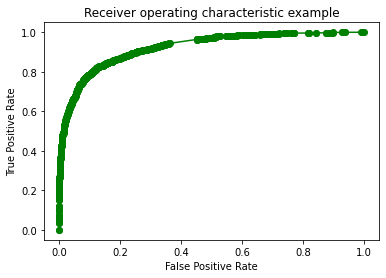

In [69]:
## ROC curve
import matplotlib.pyplot as plt
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.plot(fpr, tpr, 'go-')

In [63]:
## AUC score
skm.roc_auc_score(y_test, probs[:,1])

0.9235368326610599